# Libraries

In [4]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# importing libraries for VADER  
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import multiprocessing
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import classification_report

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

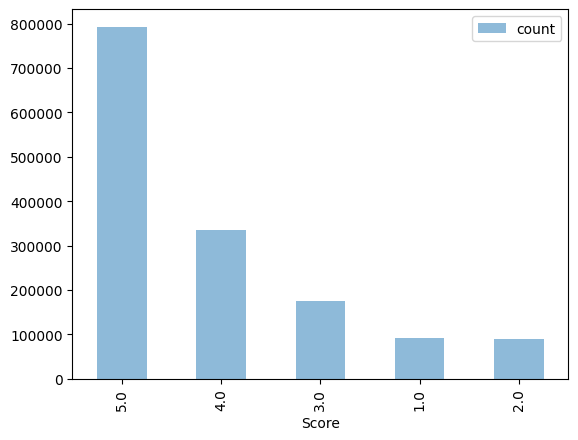


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [5]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

## Data Exploration

### Exploring Helpfulness

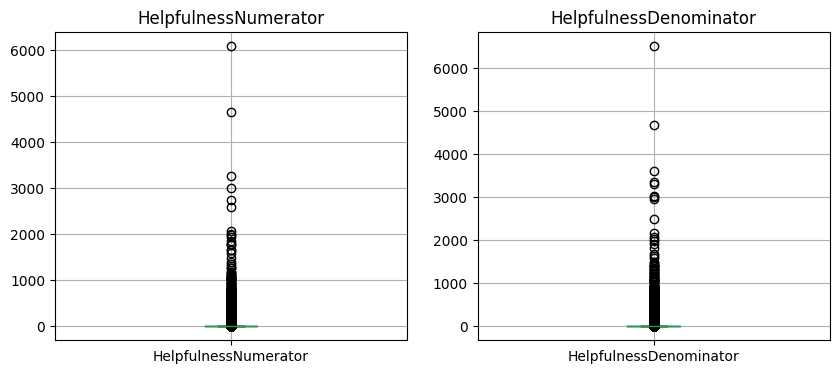

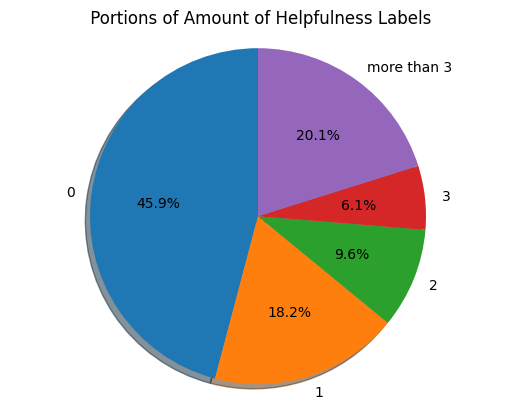

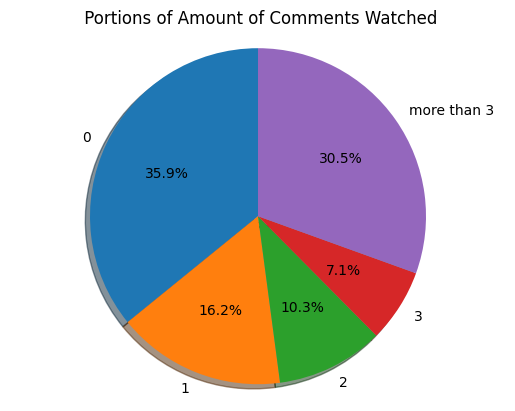

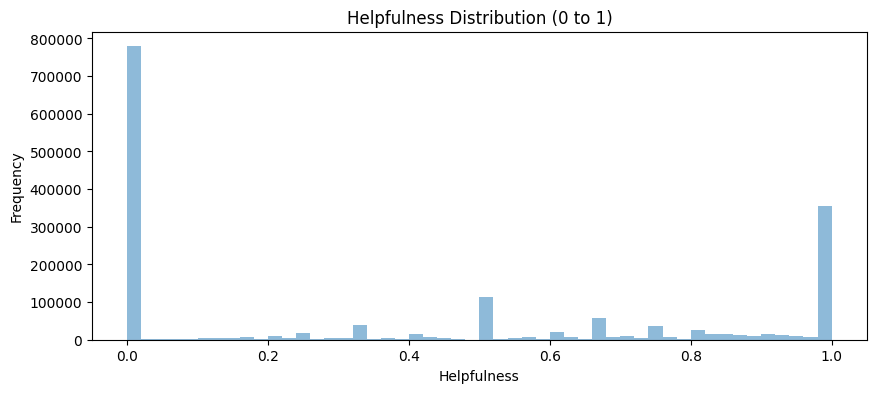

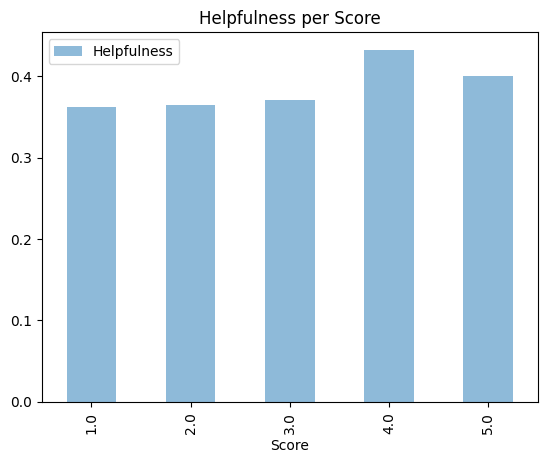

In [6]:
# Check for outliers in 'HelpfulnessNumerator' and 'HelpfulnessDenominator'
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
trainingSet.boxplot(column='HelpfulnessNumerator')
plt.title('HelpfulnessNumerator')
plt.subplot(1, 2, 2)
trainingSet.boxplot(column='HelpfulnessDenominator')
plt.title('HelpfulnessDenominator')
plt.show()

HelpfulnessNumerator0 = trainingSet[trainingSet['HelpfulnessNumerator'] == 0]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumerator1 = trainingSet[trainingSet['HelpfulnessNumerator'] == 1]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumerator2 = trainingSet[trainingSet['HelpfulnessNumerator'] == 2]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumerator3 = trainingSet[trainingSet['HelpfulnessNumerator'] == 3]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumeratorMoreThan3 = trainingSet[trainingSet['HelpfulnessNumerator'] > 3]['HelpfulnessNumerator'].value_counts()

labels = '0', '1', '2', '3', 'more than 3'
sizes = [HelpfulnessNumerator0.values.item(), HelpfulnessNumerator1.values.item(), HelpfulnessNumerator2.values.item(), 
         HelpfulnessNumerator3.values.item(), HelpfulnessNumeratorMoreThan3.values.sum()]
explode = (0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(' Portions of Amount of Helpfulness Labels')
plt.show()

HelpfulnessDenominator0 = trainingSet[trainingSet['HelpfulnessDenominator'] == 0]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominator1 = trainingSet[trainingSet['HelpfulnessDenominator'] == 1]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominator2 = trainingSet[trainingSet['HelpfulnessDenominator'] == 2]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominator3 = trainingSet[trainingSet['HelpfulnessDenominator'] == 3]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominatorMoreThan3 = trainingSet[trainingSet['HelpfulnessDenominator'] > 3]['HelpfulnessDenominator'].value_counts()

labels = '0', '1', '2', '3', 'more than 3'
sizes = [HelpfulnessDenominator0.values.item(), HelpfulnessDenominator1.values.item(), HelpfulnessDenominator2.values.item(), 
         HelpfulnessDenominator3.values.item(), HelpfulnessDenominatorMoreThan3.values.sum()]
explode = (0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(' Portions of Amount of Comments Watched')
plt.show()

trainingSet['Helpfulness'] = trainingSet['HelpfulnessNumerator'] / trainingSet['HelpfulnessDenominator']
trainingSet['Helpfulness'] = trainingSet['Helpfulness'].fillna(0)
# plotting the distribution of Helpfulness
plt.figure(figsize=(10, 4))
trainingSet['Helpfulness'].plot.hist(bins=50, alpha=0.5, range=(0, 1))
plt.title('Helpfulness Distribution (0 to 1)')
plt.xlabel('Helpfulness')
plt.ylabel('Frequency')
plt.show()

#checking skewness if HelfulnessNumerator
trainingSet[['Score', 'Helpfulness']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Helpfulness per Score")
plt.show()

**Helpfulness Numerator and Denominator Box Plots:**

The majority of values are clustered near 0, but some reviews have very high values for these fields.

**Helpfulness Pie Chart**

This distribution shows a high proportion of items either not helpful or extremely helpful, suggesting polarized perceptions of helpfulness.

**Portion of Comments Watched Pie Charts**

This indicates that a significant number of subjects either did not engage with comments at all or engaged quite extensively (more than 3 comments).

**Helpfulness**

The distribution of Helpfulness shows a very clear skew toward values close to 0 and 1, which makes sense given that most reviews are either not rated as helpful (0) or are rated highly helpful (1).
More reviews are rated as not helpful. This goes in accordance with the pie chart

**Helpfulness per Score**

Higher-rated reviews (4.0 and 5.0) are found more helpful by other users. 
There could be a potential correlation between positive reviews and perceived helpfulness.

## Exploring Class Imbalance

In [7]:
# Calculate the class imbalance
score_distribution = trainingSet['Score'].value_counts().sort_index()
class_imbalance = score_distribution.min() / score_distribution.max()
print(f"Class Frequency: {score_distribution}")
print()
print(f"Class Imbalance Ratio: {class_imbalance:.2f}")

Class Frequency: Score
1.0     91190
2.0     89678
3.0    176082
4.0    335228
5.0    793163
Name: count, dtype: int64

Class Imbalance Ratio: 0.11


**Class Imbalance**

Class imbalance is calculated as frequency of the least frequent class divided by the frequency of the most frequent class. 
In this analysis, the class imbalance ratio is 0.11, which indicates that the least frequent class appears 11% as often as the most frequent class.
This indicated a moderately high class imbalance which we will have to account for.
The class 2 is the least frequent

In [8]:
# Separate each class
class_1 = trainingSet[trainingSet['Score'] == 1]
class_2 = trainingSet[trainingSet['Score'] == 2]
class_3 = trainingSet[trainingSet['Score'] == 3]
class_4 = trainingSet[trainingSet['Score'] == 4]
class_5 = trainingSet[trainingSet['Score'] == 5]

# Downsample class 5
class_5_downsampled = resample(class_5, replace=False, n_samples=len(class_4), random_state=42)

# Optional: Upsample classes with fewer samples
class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_4), random_state=42)
class_2_upsampled = resample(class_2, replace=True, n_samples=len(class_4), random_state=42)
class_3_upsampled = resample(class_3, replace=True, n_samples=len(class_4), random_state=42)

# Combine all classes into a new balanced dataset
trainingSet_balanced = pd.concat([class_1_upsampled, class_2_upsampled, class_3_upsampled, class_4, class_5_downsampled])

In [9]:
# Calculate the class imbalance
score_distribution = trainingSet_balanced['Score'].value_counts().sort_index()
class_imbalance = score_distribution.min() / score_distribution.max()
print(f"Class Frequency: {score_distribution}")
print()
print(f"Class Imbalance Ratio: {class_imbalance:.2f}")

# perfecctly balanced dataset ? explore potential issues

Class Frequency: Score
1.0    335228
2.0    335228
3.0    335228
4.0    335228
5.0    335228
Name: count, dtype: int64

Class Imbalance Ratio: 1.00


Above we balanced the classes completely as we can see by the class imbalance ratio os 1.00, meaning equal balance thorughout. Although this can sometimes lead to a model that doesn't accurately reflect real-world data where classes are often naturally imbalanced I decided to balance the model so it wouldn't become biased towards a class.

### Exploring Text and Summary

In order to compare text and summary I will plot cloud images and see their similarity

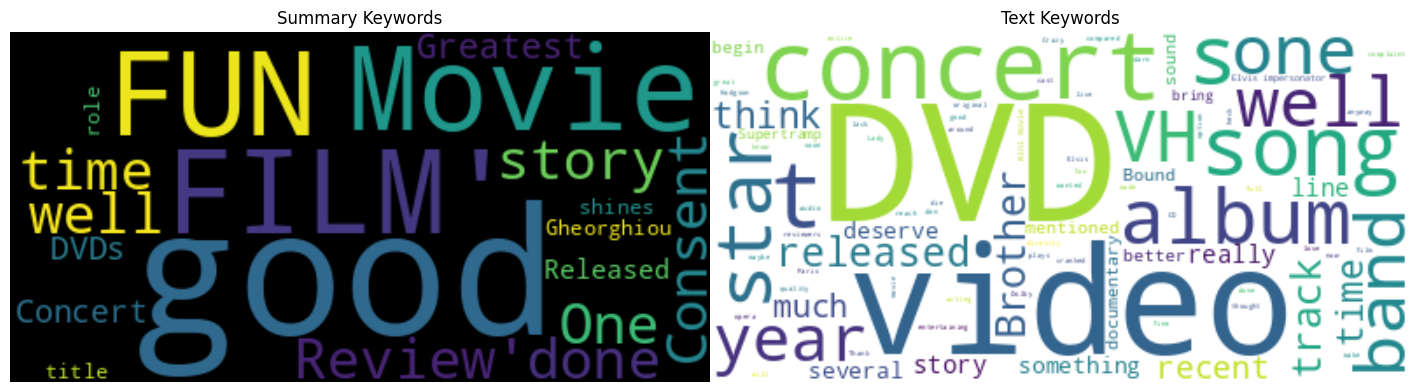

In [10]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(121)
text = trainingSet.Summary.values
wordcloud = WordCloud(
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
plt.title('Summary Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax = fig.add_subplot(122)
text = trainingSet.Text.values
wordcloud = WordCloud(
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
plt.title('Text Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Exploring Text Length

### Missing Values

Checking to see where and how many missing values exist

<Axes: >

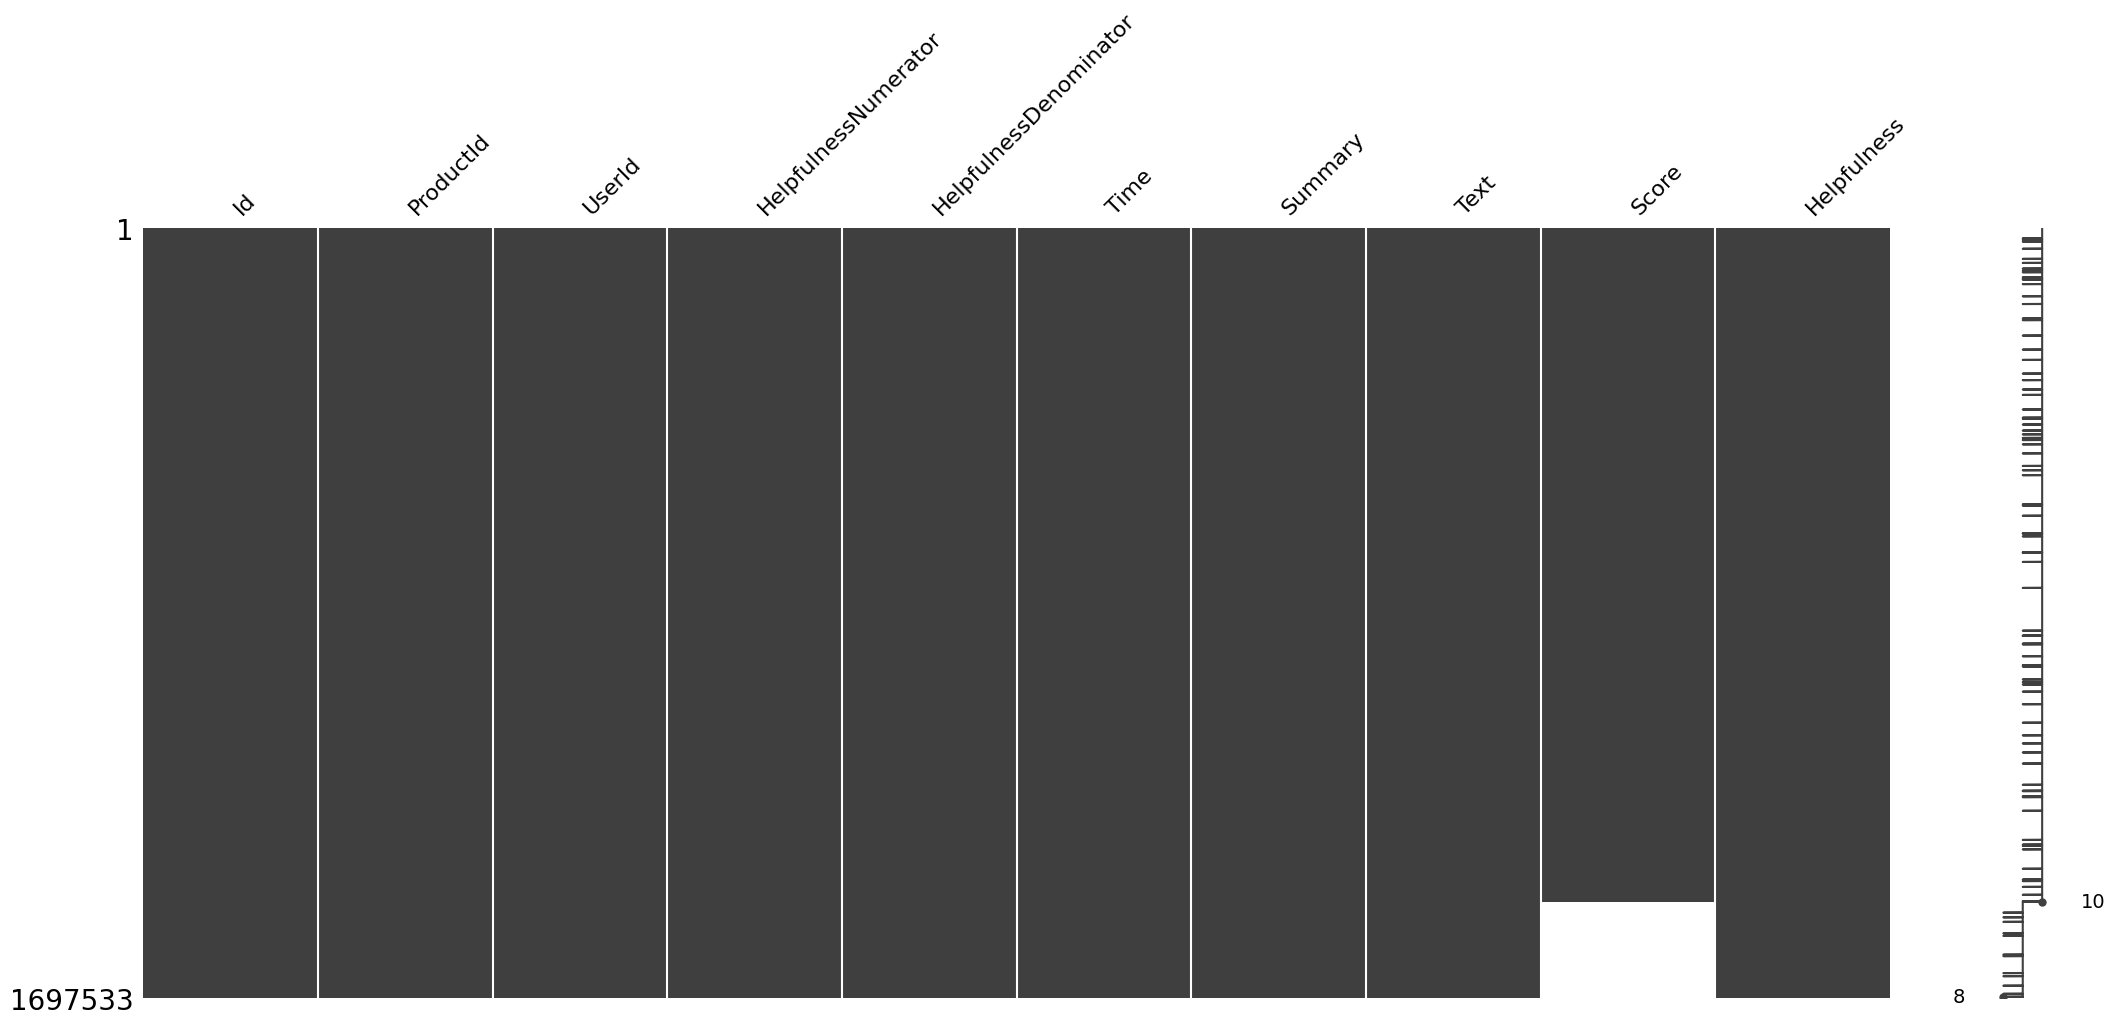

In [11]:
msno.matrix(trainingSet) 

As we can see the only missing values come from score, and there are not many.

<Axes: >

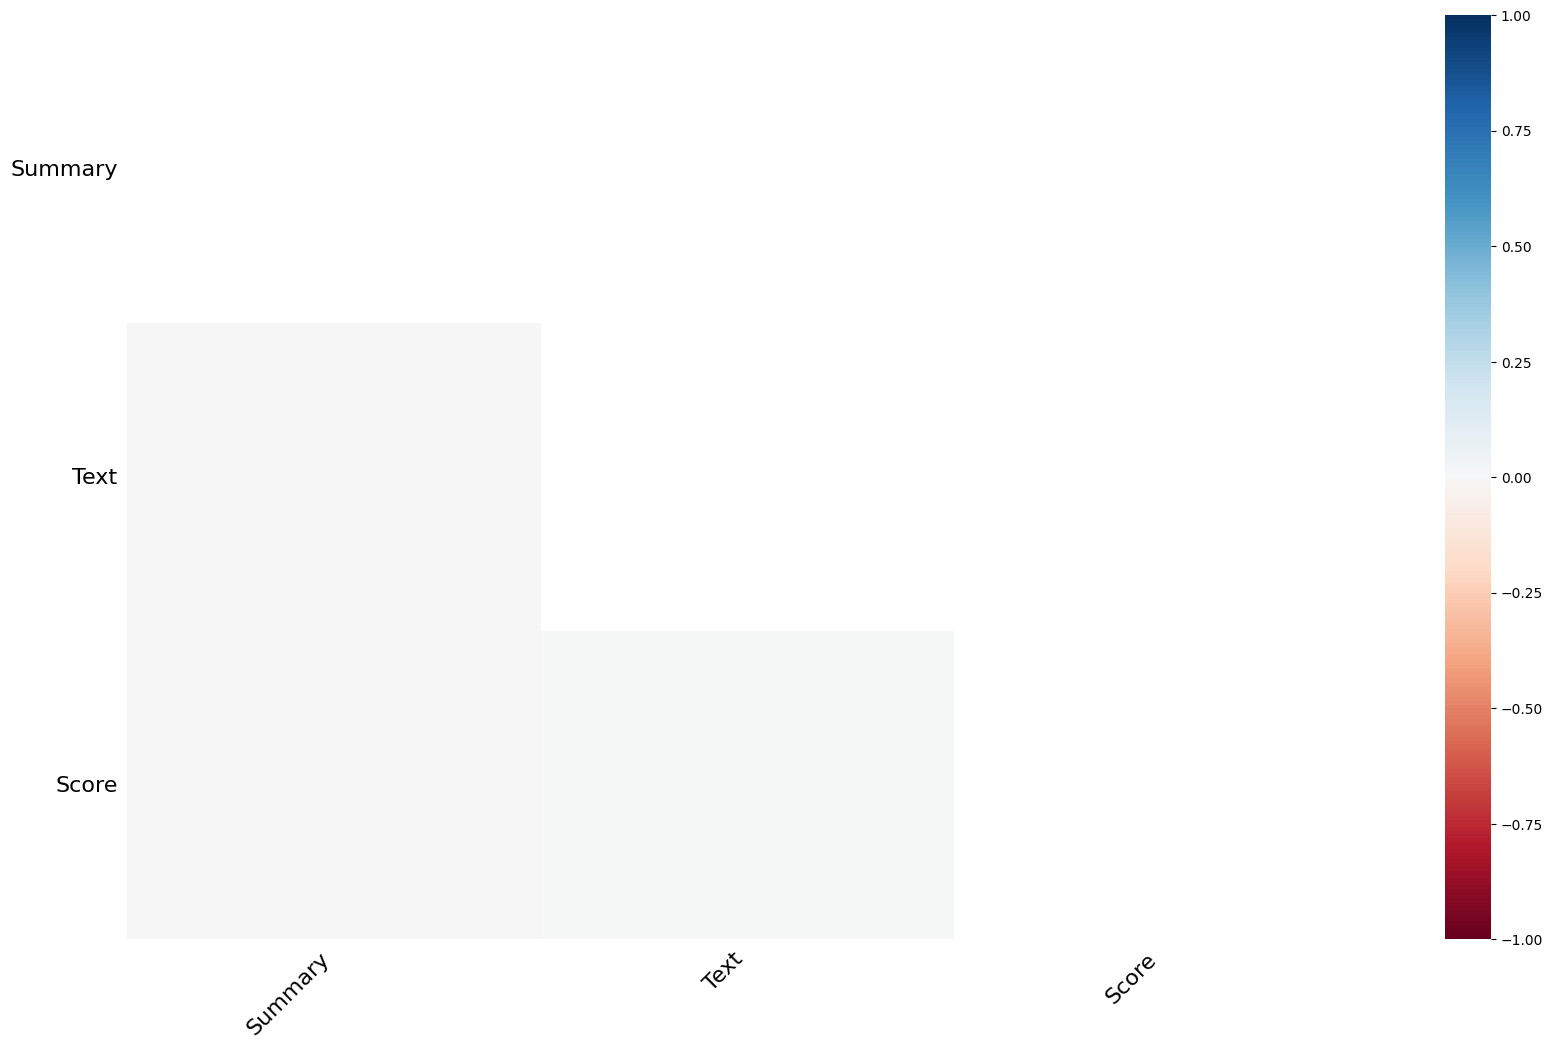

In [12]:
msno.heatmap(trainingSet)

The heatmap displays correlations between missing values across columns. A strong color (closer to -1 or 1) would indicate a strong correlation in missing data patterns between columns, meaning if one column has missing data, the other is likely to as well.


In this case, the mostly neutral, light-colored heatmap suggests minimal correlation in missingness across columns, with little overlap in missing data patterns. This indicates that missing data in one column does not predictably relate to missing data in another column.

The dataset is mostly complete, with a minor number of missing values concentrated in the Score column. Additionally, missing data across columns is uncorrelated, meaning the absence of data in one feature does not imply missing data in another.

## Vader Analysis

Playing around with Vader Analysis vs TextBlob and seeing which one to use

In [17]:
analyzer_trial = SentimentIntensityAnalyzer()

text = "While most straight to DVD films are not worth watching, this one is the exception.Kim Basinger plays a Pink Lady (Mary Kay) cosmetic sales lady who had met Elvis as a child. During her recent travels Elvis impersonators around her die from freak accidents. She falls in love with John Corbett (love at first sight) who she believes is also an Elvis impersonator because he carries around an Elvis suit which belongs to his soon to be ex-wife Denise Richards. The acting is pure ham, such as in Mars Attacks. The accents are overly done. The FBI agents hunting the pair are comical. The concept is original. The cast is full of stars (Tom Hanks, Sean Astin, Angie Dickinson, Billy Ray Cyrus, Pat Morita). The dialogue is so-so, perhaps the weakest aspect of the movie. The Elvis impersonators were so bad, you wanted them to die.Thank you. Thank you very much."
summary = "GOOD FUN FILM"

# print(trainingSet['Text'][0])
# print(trainingSet['Summary'][0])

# lets make text a little bigger and see how VADER would work
# first 100 rows
# for i in range(100):
#     print(analyzer.polarity_scores(trainingSet['Text'][i]))
#     print(analyzer.polarity_scores(trainingSet['Summary'][i]))
# 3.2 seconds for 100 rows

# now lets try to do it for the whole dataset

# sentiment_results = []
# rows_done = 0
# try: 
#     for i in range(len(trainingSet)):
#         # found out error regardin float values which come from NaN
#         # Ensure text is a string and handle non-strings (like NaN or float)
#         if not isinstance(trainingSet['Text'][i], str):
#             trainingSet.loc['Text'][i] = ''

#         sentiment = analyzer.polarity_scores(trainingSet['Text'][i])
#         sentiment_results.append(sentiment)
#         rows_done += 1

# # after five minutes 
# except KeyboardInterrupt:
#     # When you stop the code with Ctrl+C, catch the interruption and print the progress
#     print(f"Stopped after analyzing {rows_done} rows.")
#     print(f"Partial results (rows processed): {len(sentiment_results)}")
#     print(sentiment_results[:10])

print(analyzer_trial.polarity_scores(''))
# neutral score

sentiment = analyzer_trial.polarity_scores(text)

vader_neg = sentiment['neg']
vader_neu = sentiment['neu']
vader_pos = sentiment['pos']
vader_compound = sentiment['compound']

print()
print("Negative:", vader_neg)
print("Neutral:", vader_neu)
print("Positive:", vader_pos)
print("Compound:", vader_compound)

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

Negative: 0.121
Neutral: 0.78
Positive: 0.098
Compound: -0.6205


In [18]:
from textblob import TextBlob

# Create a TextBlob object
blob = TextBlob(text)

# Get sentiment
sentiment = blob.sentiment

tb_polarity = sentiment.polarity
tb_subjectivity = sentiment.subjectivity

print("Polarity:", tb_polarity)
print("Subjectivity:", tb_subjectivity)

Polarity: 0.16870535714285717
Subjectivity: 0.45687500000000003


comparison of vader vs textblob

In [21]:
results = []

results.append({
    "Text": text,
    "TextBlob Polarity": tb_polarity,
    "TextBlob Subjectivity": tb_subjectivity,
    "VADER Negative": vader_neg,
    "VADER Neutral": vader_neu,
    "VADER Positive": vader_pos,
    "VADER Compound": vader_compound
})

df_results = pd.DataFrame(results)

print(df_results)

                                                Text  TextBlob Polarity  \
0  While most straight to DVD films are not worth...           0.168705   

   TextBlob Subjectivity  VADER Negative  VADER Neutral  VADER Positive  \
0               0.456875           0.121           0.78           0.098   

   VADER Compound  
0         -0.6205  


I chose VADER for my sentiment analysis because it provides a more nuanced interpretation of sentiment in complex or mixed texts. During my tests, I found that VADER’s detailed breakdown into positive, neutral, and negative components, along with its compound score, captured subtle shifts in tone better than other tools like TextBlob. For example, in sentences with slight negative connotations, VADER was able to reflect a mildly negative sentiment where TextBlob leaned towards neutrality. This makes VADER particularly useful for analyzing informal language and capturing subtle emotional cues, which aligns well with my project’s needs.

# Adding Features

In [22]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER compound score for a given text
def get_vader_sentiment(text, idx):
    if not isinstance(text, str):
        text = ''
    if idx % 100000 == 0:  # Print progress every 100,000 rows
        print(f"Processing row {idx}")
    return analyzer.polarity_scores(text)['compound']

def parallel_vader_sentiment(df, text_column):
    num_cores = multiprocessing.cpu_count()

    sentiment_scores = Parallel(n_jobs=num_cores)(
        delayed(get_vader_sentiment)(text, i) for i, text in enumerate(df[text_column])
    )
    return sentiment_scores

def add_features_to(df):
    # This is where you can do all your feature extraction

    # Calculate 'Helpfulness' feature
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Drop HelpfulnessNumerator and HelpfulnessDenominator
    df = df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'])

    # Convert Time to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    # ridge does not work with datetime need to convert to int
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df.drop(columns=['Time'], inplace=True)

    # impute missing values with empty strings
    df['Text'] = df['Text'].fillna('').astype(str)
    df['Summary'] = df['Summary'].fillna('').astype(str)
    # Convert any non-string entries in 'Text' column to strings

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if row['Text'] else 0, axis = 1)

    # Extract the sentiment from the summary and text    
    df['Text_Sentiment'] = parallel_vader_sentiment(trainingSet, 'Text')
    # trainingSet['Summary_Sentiment'] = parallel_vader_sentiment(trainingSet, 'Summary')
    # created a lot of noise

    print(df[['Text_Sentiment']].head())
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame in chunks
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

### Exploring relationship between Text length, score and helpfulness

Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Helpfulness', 'Year',
       'Month', 'Day', 'DayOfWeek', 'ReviewLength', 'Text_Sentiment'],
      dtype='object')
Correlation Matrix:
                ReviewLength  Helpfulness  Text_Sentiment
ReviewLength        1.000000     0.304723       -0.009702
Helpfulness         0.304723     1.000000        0.036624
Text_Sentiment     -0.009702     0.036624        1.000000


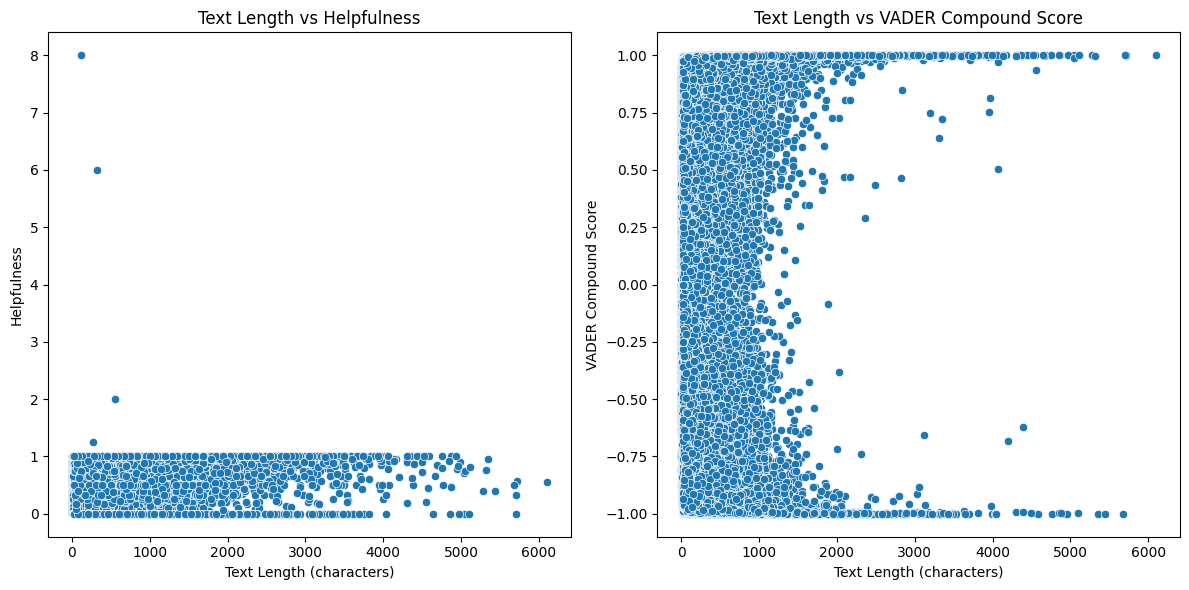

In [33]:
# create a copy of training set to avoid any changes
df = X_train.copy()

# column
print(df.columns)

# # create a text length feature
# df['text_length'] = df.apply(lambda row : len(row['Text'].split()) if row['Text'] else 0, axis = 1)

# Calculate correlation between text length, helpfulness, and sentiment scores
correlations = df[['ReviewLength', 'Helpfulness', 'Text_Sentiment']].corr()

# Display the correlations
print("Correlation Matrix:")
print(correlations)

# Plotting the relationships
plt.figure(figsize=(12, 6))

# Text Length vs Helpfulness
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='ReviewLength', y='Helpfulness')
plt.title("Text Length vs Helpfulness")
plt.xlabel("Text Length (characters)")
plt.ylabel("Helpfulness")

# Text Length vs VADER Compound Score
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='ReviewLength', y='Text_Sentiment')
plt.title("Text Length vs VADER Compound Score")
plt.xlabel("Text Length (characters)")
plt.ylabel("VADER Compound Score")

plt.tight_layout()
plt.show()

The analysis shows that longer reviews tend to be rated as more helpful, although length alone doesn’t guarantee helpfulness, as many long reviews still have low helpfulness scores. There is no meaningful correlation between text length and sentiment score, meaning the sentiment (positive or negative) of a review is independent of its length. This suggests that detailed reviews may be more valued for helpfulness, but sentiment relies more on the content than on length.

Even though length alone doesn’t guarantee a high helpfulness rating, longer reviews generally provide more information, which might contribute positively to the model’s ability to predict helpfulness scores.

Vader is taking a long time, the following code is simply me trying to determine exactly where the bottleneck is/was.

In [ ]:
import cProfile

# Profile the function to see where it is slow
cProfile.run('add_features_to(trainingSet)')

From the output I got i'm seeing that VADER that a long time computationally since it goes row by row processing.
There seems to be a bottleneck in the add_features_to() function — 192.257 seconds. The lambda functions responsible for sentiment analysis (<lambda>) and the chunk processing (process_chunk) are also contributing heavily to the runtime.

FIXED with parallel computing (below)

# Sample + Split into training and testing set

In [24]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=42
)

debugging: was getting an error that Text_Sentiment was inexistent, so added the following code to check columns as I go

In [25]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_submission:", X_submission.columns)

Columns in X_train: Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Helpfulness', 'Year',
       'Month', 'Day', 'DayOfWeek', 'ReviewLength', 'Text_Sentiment'],
      dtype='object')
Columns in X_submission: Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Helpfulness', 'Year',
       'Month', 'Day', 'DayOfWeek', 'ReviewLength', 'Text_Sentiment', 'Score'],
      dtype='object')


# Feature Selection

In [26]:
features = ['Id', 'Text_Sentiment', 'Helpfulness', 'DayOfWeek', 'ReviewLength']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [27]:
# Define parameter distributions
param_distributions = {
    'n_estimators': [50, 100, 150, 200],        # Try different values for the number of trees
    'learning_rate': np.linspace(0.01, 0.2, 5), # Range for learning rates (5 values between 0.01 and 0.2)
    'max_depth': [3, 4, 5, 6, 7],               # Different max depth values
    'subsample': [0.6, 0.8, 1.0],               # Include subsample parameter to control overfitting
    'min_samples_split': [2, 5, 10]             # Minimum number of samples required to split a node
}

# Initialize RandomizedSearchCV with GradientBoostingClassifier
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,                        # Number of parameter settings to sample
    scoring='accuracy',                # Scoring metric for evaluation
    cv=3,                              # 3-fold cross-validation
    n_jobs=-1,                         # Use all available cores
    verbose=3,                         # Print progress
    random_state=42                    # Set random state for reproducibility
)

# Select a smaller subset to reduce runtime
X_train_small = X_train_select.sample(frac=0.1, random_state=42)  # 10% of the data
Y_train_small = Y_train.loc[X_train_small.index]

# Fit RandomizedSearchCV
random_search.fit(X_train_small, Y_train_small)

# Retrieve the best model and parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Use the best model to make predictions
Y_test_predictions = best_model.predict(X_test_select)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END learning_rate=0.0575, max_depth=4, min_samples_split=5, n_estimators=100, subsample=0.6;, score=0.552 total time=  36.9s
[CV 2/3] END learning_rate=0.0575, max_depth=4, min_samples_split=5, n_estimators=100, subsample=0.6;, score=0.554 total time=  36.9s
[CV 1/3] END learning_rate=0.15250000000000002, max_depth=4, min_samples_split=5, n_estimators=50, subsample=0.6;, score=0.552 total time=  19.5s
[CV 3/3] END learning_rate=0.0575, max_depth=4, min_samples_split=5, n_estimators=100, subsample=0.6;, score=0.556 total time=  38.4s
[CV 2/3] END learning_rate=0.15250000000000002, max_depth=4, min_samples_split=5, n_estimators=50, subsample=0.6;, score=0.555 total time=  18.9s
[CV 3/3] END learning_rate=0.15250000000000002, max_depth=4, min_samples_split=5, n_estimators=50, subsample=0.6;, score=0.555 total time=  19.4s
[CV 3/3] END learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.8

debugging:

In [28]:
print("X_train_select shape:", X_train_select.shape)
print("Y_train shape:", Y_train.shape)
print("X_train_small shape:", X_train_small.shape)
print("Y_train_small shape:", Y_train_small.shape)

X_train_select shape: (1114005, 5)
Y_train shape: (1114005,)
X_train_small shape: (111400, 5)
Y_train_small shape: (111400,)


best parameters found from above are

        subsample: 1.0

        n_estimators: 200

        min_samples_split: 2

        max_depth: 3

        learning_rate: 0.2

based on cross-validated accuracy scores for each combination tested.
These have been changing as I updated the model

In [34]:
best_params = random_search.best_params_
final_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=1.0,
    min_samples_split=2,
    random_state=42
)

# Fit the model on the full training data
final_model.fit(X_train_select, Y_train)

# Predict on the test data
Y_test_predictions = final_model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5593586401533921


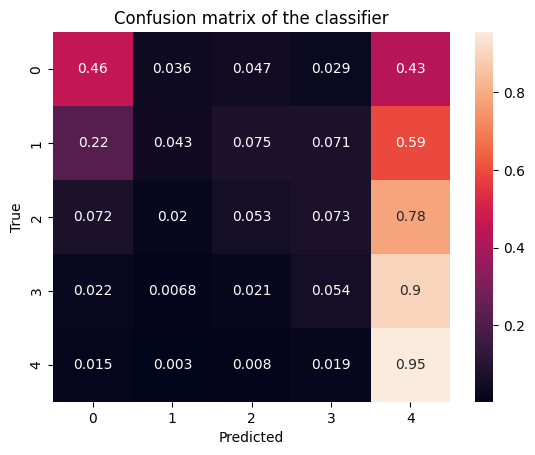

Classification Report:
               precision    recall  f1-score   support

         1.0       0.45      0.46      0.45     22649
         2.0       0.25      0.04      0.07     22182
         3.0       0.28      0.05      0.09     43979
         4.0       0.33      0.05      0.09     83939
         5.0       0.59      0.95      0.73    198587

    accuracy                           0.56    371336
   macro avg       0.38      0.31      0.29    371336
weighted avg       0.46      0.56      0.45    371336



In [35]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
# previous accuracy was 0.5566764332033522

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

report = classification_report(Y_test, Y_test_predictions)
print("Classification Report:\n", report)

# Create submission file

In [36]:
# Create the submission file
X_submission['Score'] = final_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)